In [1]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
cd ../..

/userdata/jgauthier/projects/ideal-word-representations


In [4]:
pval_threshold = 1e-3
output_dir = "."

In [5]:
encoder_comparisons = list(Path("outputs/encoder_comparison").glob("*/*/*/*"))
encoder_comparison_names = ["dataset", "subject", "model2", "model1"]
encoder_comparison_keys = [(path.parts[-4], path.parts[-3], path.parts[-2], path.parts[-1]) for path in encoder_comparisons]

In [6]:
all_ttest_results = pd.concat(
    [pd.read_csv(path / "ttest_results.csv") for path in encoder_comparisons],
    names=encoder_comparison_names,
    keys=encoder_comparison_keys)
all_ttest_results

output_dim permutation        tval  \
dataset subject model2       model1                                            
timit   EC260   biphone_pred baseline 0          206       shift  800.648723   
                                      1          221       shift   96.024424   
                                      2          190       shift   34.390189   
                                      3          237       shift   20.354256   
                                      4          223       shift   18.367237   
...                                              ...         ...         ...   
        EC196   phoneme      baseline 89         226       units         NaN   
                                      90         240       units         NaN   
                                      91         244       units         NaN   
                                      92         246       units         NaN   
                                      93         255       units         NaN   

                                                  pval  
dataset subject model2       model1                     
timit   EC260   biphone_pred baseline 0   1.460087e-11  
                                      1   7.051970e-08  
                                      2   4.265489e-06  
                                      3   3.440123e-05  
                                      4   5.169422e-05  
...                                                ...  
        EC196   phoneme      baseline 89           NaN  
                                      90           NaN  
                                      91           NaN  
                                      92           NaN  
                                      93           NaN  

[5010 rows x 4 columns]

In [7]:
all_scores_df = pd.concat([
        # whoops, output_name is a tuple -- let's read it as such
        pd.read_csv(path / "scores.csv", converters={"output_name": ast.literal_eval}) for path in encoder_comparisons
    ], keys=encoder_comparison_keys, names=encoder_comparison_names) \
    .reset_index(level=-1, drop=True)
all_scores_df["electrode_name"] = all_scores_df.output_name.str[1]
all_scores_df = all_scores_df.set_index("electrode_name", append=True)
all_scores_df

model  output_dim  \
dataset subject model2       model1   electrode_name                         
timit   EC260   biphone_pred baseline FG1             baseline           0   
                                      FG1             baseline           0   
                                      FG1             baseline           0   
                                      FG2             baseline           1   
                                      FG2             baseline           1   
...                                                        ...         ...   
        EC196   phoneme      baseline GA127            phoneme         254   
                                      GA127            phoneme         254   
                                      GA128            phoneme         255   
                                      GA128            phoneme         255   
                                      GA128            phoneme         255   

                                                      fold     score  \
dataset subject model2       model1   electrode_name                   
timit   EC260   biphone_pred baseline FG1                0 -0.000562   
                                      FG1                1  0.000061   
                                      FG1                2 -0.000027   
                                      FG2                0 -0.004349   
                                      FG2                1 -0.001013   
...                                                    ...       ...   
        EC196   phoneme      baseline GA127              1 -0.000702   
                                      GA127              2  0.000559   
                                      GA128              0 -0.002314   
                                      GA128              1 -0.000995   
                                      GA128              2 -0.000643   

                                                       output_name  
dataset subject model2       model1   electrode_name                
timit   EC260   biphone_pred baseline FG1                 (0, FG1)  
                                      FG1                 (0, FG1)  
                                      FG1                 (0, FG1)  
                                      FG2                 (1, FG2)  
                                      FG2                 (1, FG2)  
...                                                            ...  
        EC196   phoneme      baseline GA127           (254, GA127)  
                                      GA127           (254, GA127)  
                                      GA128           (255, GA128)  
                                      GA128           (255, GA128)  
                                      GA128           (255, GA128)  

[69888 rows x 5 columns]

In [8]:
all_electrodes_keys = [(dataset, subject, model2) for dataset, subject, model2, model1 in encoder_comparison_keys]
all_electrodes_paths = [Path("outputs/encoders") / dataset / model2 / subject / "electrodes.csv"
                        for dataset, subject, model2 in all_electrodes_keys]
all_electrodes_df = pd.concat([
        pd.read_csv(path) for path in all_electrodes_paths
    ], keys=all_electrodes_keys, names=["dataset", "subject", "model"]) \
    .droplevel(-1)
all_electrodes_df

electrode_idx electrode_name      long_name  \
dataset subject model                                                       
timit   EC260   biphone_pred              0            FG1   FrontalGrid1   
                biphone_pred              1            FG2   FrontalGrid2   
                biphone_pred              2            FG3   FrontalGrid3   
                biphone_pred              3            FG4   FrontalGrid4   
                biphone_pred              4            FG5   FrontalGrid5   
...                                     ...            ...            ...   
        EC196   phoneme                 303            HD6   Hippocampus6   
                phoneme                 304            HD7   Hippocampus7   
                phoneme                 305            HD8   Hippocampus8   
                phoneme                 306            HD9   Hippocampus9   
                phoneme                 307           HD10  Hippocampus10   

                               type                         roi  
dataset subject model                                            
timit   EC260   biphone_pred   grid            parstriangularis  
                biphone_pred   grid            parstriangularis  
                biphone_pred   grid            parstriangularis  
                biphone_pred   grid             parsopercularis  
                biphone_pred   grid             parsopercularis  
...                             ...                         ...  
        EC196   phoneme       depth  Left-Cerebral-White-Matter  
                phoneme       depth  Left-Cerebral-White-Matter  
                phoneme       depth  Left-Cerebral-White-Matter  
                phoneme       depth  Left-Cerebral-White-Matter  
                phoneme       depth       ctx_lh_S_temporal_inf  

[14112 rows x 5 columns]

<Axes: xlabel='model', ylabel='subject'>

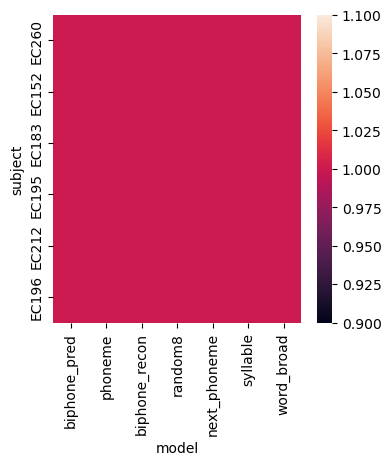

In [9]:
covered_models = list(all_ttest_results.index.get_level_values("model2").unique())
covered_subjects = list(all_ttest_results.index.get_level_values("subject").unique())
coverage_df = pd.DataFrame(np.zeros((len(covered_subjects), len(covered_models)), dtype=int),
                           columns=pd.Index(covered_models, name="model"),
                            index=pd.Index(covered_subjects, name="subject"))
for dataset, subject, model2, model1 in encoder_comparison_keys:
    coverage_df.loc[subject, model2] += 1
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(coverage_df, fmt=",d")

In [70]:
# # Merge in electrode information
# all_scores_df = pd.merge(
#     all_scores_df,
#     all_electrodes_df.rename(columns=lambda col: f"electrode_{col}" if not col.startswith("electrode") else col),
#     left_index=True, right_index=True,
#     how="left", validate="many_to_one")

In [71]:
# all_scores_df.to_csv(Path(output_dir) / "all_encoding_scores.csv")
# all_electrodes_df.to_csv(Path(output_dir) / "all_electrodes.csv")

## Electrode selection

In [18]:
# For each dataset-subject-model1-model2-electrode, take the permutation which yields the LARGEST pvalue
# This is a more stringent test of improvement
ttest_results_filtered = all_ttest_results.groupby(["dataset", "subject", "model2", "model1", "output_dim"]).apply(lambda df: df.loc[df.pval.idxmax()])
ttest_results_filtered = ttest_results_filtered[(ttest_results_filtered.tval > 0) & (ttest_results_filtered.pval < pval_threshold)] \
    .sort_values("pval")
ttest_results_filtered.to_csv(Path(output_dir) / "ttest_results_filtered.csv")
ttest_results_filtered

output_dim permutation  \
dataset subject model2        model1   output_dim                           
timit   EC212   phoneme       baseline 201                201       shift   
        EC260   biphone_pred  baseline 206                206       shift   
                biphone_recon baseline 206                206       shift   
        EC212   biphone_pred  baseline 201                201       shift   
        EC260   phoneme       baseline 206                206       shift   
...                                                       ...         ...   
        EC183   biphone_pred  baseline 69                  69       shift   
                syllable      baseline 51                  51       units   
        EC196   next_phoneme  baseline 85                  85       shift   
        EC195   biphone_recon baseline 28                  28       shift   
        EC260   biphone_pred  baseline 202                202       shift   

                                                          tval          pval  
dataset subject model2        model1   output_dim                             
timit   EC212   phoneme       baseline 201         1051.367209  4.910559e-12  
        EC260   biphone_pred  baseline 206          800.648723  1.460087e-11  
                biphone_recon baseline 206          789.107130  1.547400e-11  
        EC212   biphone_pred  baseline 201          574.341928  5.513919e-11  
        EC260   phoneme       baseline 206          572.531062  5.584010e-11  
...                                                        ...           ...  
        EC183   biphone_pred  baseline 69             8.762419  9.350969e-04  
                syllable      baseline 51             8.708415  9.575238e-04  
        EC196   next_phoneme  baseline 85             8.695729  9.628882e-04  
        EC195   biphone_recon baseline 28             8.689139  9.656896e-04  
        EC260   biphone_pred  baseline 202            8.672717  9.727148e-04  

[637 rows x 4 columns]

## Summary quantitative analysis

In [19]:
all_scores_df

model  output_dim  \
dataset subject model2       model1   electrode_name                         
timit   EC260   biphone_pred baseline FG1             baseline           0   
                                      FG1             baseline           0   
                                      FG1             baseline           0   
                                      FG2             baseline           1   
                                      FG2             baseline           1   
...                                                        ...         ...   
        EC196   phoneme      baseline GA127            phoneme         254   
                                      GA127            phoneme         254   
                                      GA128            phoneme         255   
                                      GA128            phoneme         255   
                                      GA128            phoneme         255   

                                                      fold     score  \
dataset subject model2       model1   electrode_name                   
timit   EC260   biphone_pred baseline FG1                0 -0.000562   
                                      FG1                1  0.000061   
                                      FG1                2 -0.000027   
                                      FG2                0 -0.004349   
                                      FG2                1 -0.001013   
...                                                    ...       ...   
        EC196   phoneme      baseline GA127              1 -0.000702   
                                      GA127              2  0.000559   
                                      GA128              0 -0.002314   
                                      GA128              1 -0.000995   
                                      GA128              2 -0.000643   

                                                       output_name  
dataset subject model2       model1   electrode_name                
timit   EC260   biphone_pred baseline FG1                 (0, FG1)  
                                      FG1                 (0, FG1)  
                                      FG1                 (0, FG1)  
                                      FG2                 (1, FG2)  
                                      FG2                 (1, FG2)  
...                                                            ...  
        EC196   phoneme      baseline GA127           (254, GA127)  
                                      GA127           (254, GA127)  
                                      GA128           (255, GA128)  
                                      GA128           (255, GA128)  
                                      GA128           (255, GA128)  

[69888 rows x 5 columns]

In [20]:
# # plot baseline performance
# baseline_scores = all_scores_df.xs("baseline", level="model")
# plot_df = baseline_scores.groupby(["subject", "electrode_roi", "electrode_name"]).score.mean().reset_index()

# f, ax = plt.subplots(figsize=(15, 8))
# sns.barplot(data=plot_df, x="subject", y="score", ax=ax)
# ax.set_title("Mean baseline r^2 by subject, across all electrodes")

In [21]:
# # plot baseline performance
# baseline_scores = all_scores_df.xs("baseline", level="model")
# plot_df = baseline_scores.groupby(["subject", "fold"]).score.max().reset_index()

# f, ax = plt.subplots(figsize=(15, 8))
# sns.barplot(data=plot_df, x="subject", y="score", ax=ax)
# ax.set_title("Max baseline r^2 by subject, across all electrodes")

In [22]:
# def compute_improvement_within_fold(fold_df):
#     print(fold_df.score)
#     ret = fold_df.score - fold_df.xs("baseline", level="model").score
#     print(ret)
#     return ret

# # all_scores_df.groupby(["subject", "output_name"]).apply(compute_improvement_within_fold)
# improvement_df = all_scores_df.set_index(["fold", "output_name"], append=True)
# improvement_df = pd.merge(improvement_df, (improvement_df.score - improvement_df.xs("baseline", level="model").score).rename("improvement"),
#                           left_index=True, right_index=True)
# improvement_df = improvement_df.loc[improvement_df.index.get_level_values("model") != "baseline"]
# improvement_df

In [23]:
# improvement_df.groupby(["subject", "output_name", "model"]).improvement.mean().sort_values(ascending=False)

In [24]:
# f, ax = plt.subplots(figsize=(15, 8))
# plot_df = improvement_df.groupby(["subject", "model", "output_name"]).improvement.mean().reset_index()
# sns.boxplot(data=plot_df, order=plot_df.groupby("model").improvement.mean().sort_values(ascending=False).index,
#             x="model", y="improvement", hue="subject", ax=ax)

In [25]:
# f, ax = plt.subplots(figsize=(15, 8))
# plot_df = improvement_df.groupby(["subject", "model", "output_name"]).improvement.mean().reset_index()
# sns.barplot(data=plot_df, order=plot_df.groupby("subject").improvement.mean().sort_values(ascending=False).index,
#             x="subject", y="improvement", hue="model", ax=ax)
# ax.set_title("Mean improvement across electrodes within subject and model")

In [26]:
# f, ax = plt.subplots(figsize=(15, 8))
# plot_df = improvement_df.groupby(["subject", "model", "fold"]).improvement.max().reset_index()
# sns.barplot(data=plot_df, order=plot_df.groupby("subject").improvement.mean().sort_values(ascending=False).index,
#             x="subject", y="improvement", hue="model", ax=ax)
# ax.set_title("Max improvement across electrodes within subject and model")

/tmp/ipykernel_2323893/4084023210.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


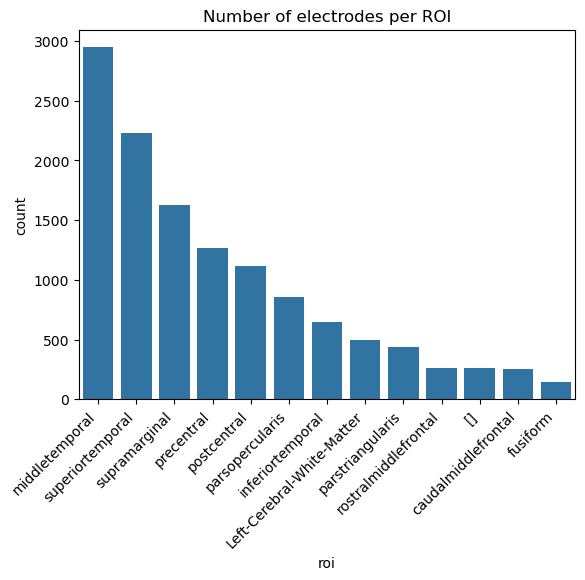

In [33]:
plot_df = all_electrodes_df.roi.value_counts()
plot_df = plot_df[plot_df / plot_df.sum() >= 0.01]
ax = sns.barplot(data=plot_df)
ax.set_title("Number of electrodes per ROI")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
None

In [28]:
# f, ax = plt.subplots(figsize=(15, 8))
# sns.barplot(data=improvement_df.reset_index(),
#             x="model", y="improvement", hue="electrode_roi", ax=ax)
# ax.set_title("Mean improvement across subject, electrode within ROI and model")

In [29]:
# f, ax = plt.subplots(figsize=(15, 8))
# sns.barplot(data=improvement_df.reset_index(),
#             order=improvement_df.reset_index().groupby("electrode_roi").improvement.mean().sort_values(ascending=False).index,
#             x="electrode_roi", y="improvement", hue="model",
#             ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# ax.set_title("Mean improvement across subject, electrode within ROI and model")

In [30]:
# f, ax = plt.subplots(figsize=(15, 8))
# plot_df = improvement_df.groupby(["subject", "electrode_roi", "model", "fold"]).improvement.max().reset_index()
# sns.barplot(data=plot_df,
#             order=plot_df.groupby("electrode_roi").improvement.mean().sort_values(ascending=False).index,
#             x="electrode_roi", y="improvement", hue="model",
#             ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# ax.set_title("Max improvement across subject, electrode within ROI and model")